In [1]:
import numpy as np

# prediction vectors: shape is (n_samples, 2) of long/lat displacements in degrees
train_preds = np.load("/g/data/x77/jm0124/feature_vectors/feature-array-outputs-uv-train.npy")[:,[0,1]]
val_preds   = np.load("/g/data/x77/jm0124/feature_vectors/feature-array-outputs-uv-val.npy")  [:,[0,1]]
test_preds  = np.load("/g/data/x77/jm0124/feature_vectors/feature-array-outputs-uv-test.npy") [:,[0,1]]

import json
def load_labels(f):
    with open(f, 'r') as f2:
        j = json.load(f2)
    ids = j.keys()
    labels = []
    latent = []
    for id_ in ids:
        # JSON object has label: [[long_old, long_new], [lat_old, lat_new], [inten, inten]],
        # time: int, index: int
        long, lat, inten = j[id_]['label']
        labels.append([long[1] - long[0], lat[1] - lat[0]])
        latent.append([long[0], lat[0], inten[0]])
    return np.array(labels), np.array(latent)

# Latent stores associated lists of [old_long, old_lat, intensity]
train_labels, train_latent = load_labels("/g/data/x77/jm0124/feature_vectors/train_feature_labels.json")
val_labels,   val_latent   = load_labels("/g/data/x77/jm0124/feature_vectors/val_feature_labels.json")
test_labels,  test_latent  = load_labels("/g/data/x77/jm0124/feature_vectors/test_feature_labels.json")

In [2]:
assert train_preds.shape == train_labels.shape
assert val_preds.shape == val_labels.shape
assert test_preds.shape == test_labels.shape

In [3]:
from enum import IntEnum
class Hemisphere(IntEnum):
    South = 0
    North = 1
    def __repr__(self):
        if self == Hemisphere.North: return "North"
        elif self == Hemisphere.South: return "South"

from collections import defaultdict
def bin_by_intensity_and_hemi(preds, true, latent):
    mask = abs((true - preds)).sum(axis=1) < 90
    # returns a (default)dict where keys are intensities and values
    # are lists of (pred, true, latent) tuples where each is an ndarray
    bins = defaultdict(list)
    for i in range(len(preds)):
        if mask[i]:
            inten = latent[i,2]
            hemi = Hemisphere.South if true[i][1] < 0 else Hemisphere.North
            bins[(inten, hemi)].append((preds[i],true[i],latent[i]))
    return bins

train_bins = bin_by_intensity_and_hemi(train_preds, train_labels, train_latent)
val_bins   = bin_by_intensity_and_hemi(val_preds,   val_labels,   val_latent  )
test_bins  = bin_by_intensity_and_hemi(test_preds,  test_labels,  test_latent )

In [4]:
# Counting timesteps
buckets = sorted(train_bins.keys())
for key in buckets:
    print(f"{key}: {len(train_bins[key])}")

(-5.0, South): 9820
(-5.0, North): 10759
(-4.0, South): 689
(-4.0, North): 1297
(-3.0, South): 2853
(-3.0, North): 5839
(-2.0, South): 407
(-2.0, North): 483
(-1.0, South): 15905
(-1.0, North): 27151
(0.0, South): 18677
(0.0, North): 33338
(1.0, South): 5435
(1.0, North): 11651
(2.0, South): 2397
(2.0, North): 5786
(3.0, South): 1913
(3.0, North): 4474
(4.0, South): 1289
(4.0, North): 4069
(5.0, South): 182
(5.0, North): 915


In [5]:
# Getting sample covariance for each bucket
train_res = defaultdict(list)
train_cov = defaultdict(list)
for key in buckets:
    longlat_residuals = np.array([t[1]-t[0] for t in train_bins[key]])
    train_res[key] = longlat_residuals
    train_cov[key] = np.cov(longlat_residuals.T)

val_res = defaultdict(list)
val_cov = defaultdict(list)
for key in buckets:
    longlat_residuals = np.array([t[1]-t[0] for t in val_bins[key]])
    val_res[key] = longlat_residuals
    val_cov[key] = np.cov(longlat_residuals.T)

test_res = defaultdict(list)
test_cov = defaultdict(list)
for key in buckets:
    longlat_residuals = np.array([t[1]-t[0] for t in test_bins[key]])
    test_res[key] = longlat_residuals
    test_cov[key] = np.cov(longlat_residuals.T)

for key in buckets:
    cov = train_cov[key].tolist()
    print(f"{key}: [[{cov[0][0]:.3f}, {cov[0][1]:.3f}], [{cov[1][0]:.3f}, {cov[1][1]:.3f}]]")

(-5.0, South): [[0.672, -0.022], [-0.022, 0.383]]
(-5.0, North): [[0.798, 0.002], [0.002, 0.388]]
(-4.0, South): [[0.958, -0.004], [-0.004, 0.470]]
(-4.0, North): [[2.132, 0.146], [0.146, 0.605]]
(-3.0, South): [[0.272, -0.002], [-0.002, 0.213]]
(-3.0, North): [[0.303, 0.015], [0.015, 0.242]]
(-2.0, South): [[0.494, -0.010], [-0.010, 0.230]]
(-2.0, North): [[0.529, 0.018], [0.018, 0.321]]
(-1.0, South): [[0.341, -0.008], [-0.008, 0.256]]
(-1.0, North): [[0.328, 0.016], [0.016, 0.251]]
(0.0, South): [[0.337, -0.020], [-0.020, 0.257]]
(0.0, North): [[0.337, 0.038], [0.038, 0.234]]
(1.0, South): [[0.287, -0.026], [-0.026, 0.211]]
(1.0, North): [[0.342, 0.030], [0.030, 0.221]]
(2.0, South): [[0.290, -0.015], [-0.015, 0.216]]
(2.0, North): [[0.294, 0.039], [0.039, 0.197]]
(3.0, South): [[0.238, -0.022], [-0.022, 0.201]]
(3.0, North): [[0.226, 0.025], [0.025, 0.180]]
(4.0, South): [[0.204, -0.024], [-0.024, 0.169]]
(4.0, North): [[0.197, 0.032], [0.032, 0.168]]
(5.0, South): [[0.184, -0.027]

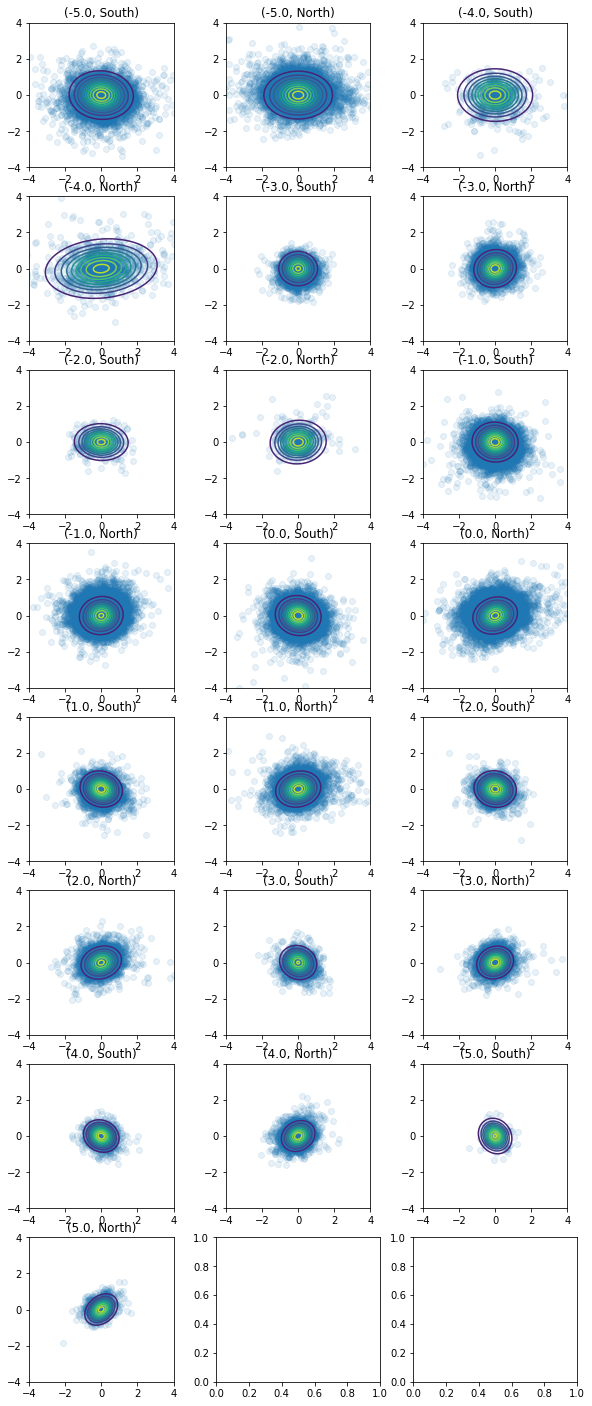

In [6]:
# Plotting samples on top of a N(0, sample_cov) contour
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
import math

def plot_bucket(ax, key):
    ax.axis(xmin=-4, xmax=4, ymin=-4, ymax=4)
    ax.set_aspect('equal', adjustable='box')
    # contour
    x, y = np.mgrid[-4:4:.05, -4:4:.05]
    rv = multivariate_normal([0, 0], train_cov[key])
    data = np.dstack((x, y))
    z = rv.pdf(data)
    ax.contour(x, y, z, levels=10)
    # scatter the points
    x, y = train_res[key].T
    ax.scatter(x, y, alpha=0.1)
    ax.set_title(key)

fig, ax = plt.subplots(nrows=math.ceil(len(buckets)/3), ncols=3)
fig.set_size_inches(10, 25)
axes = [col for row in ax for col in row]
for ax, key in zip(axes, buckets):
    plot_bucket(ax, key)
plt.show()

Log likelihood using our refined covariance estimates and the global sample covariance of the training, validation and test sets

In [7]:
import math
def log_zeromean_multivariate_normal_pdf(x, cov):
    k = cov.shape[0]
    return -0.5 * (k * math.log(2*math.pi) + math.log(np.linalg.det(cov)) + x.T @ np.linalg.pinv(cov) @ x)

def log_likelihood(preds, cov):
    p_values = []
    for x in preds:
        p_values.append(log_zeromean_multivariate_normal_pdf(x, cov))
    return sum(p_values)

In [8]:
def likelihood_stats(res, cov, labels, preds):
    refined_log_likelihood = sum([log_likelihood(res[key], cov[key]) for key in buckets])
    print(f"Log likelihood = {refined_log_likelihood} using binned sample covariances from training set")
    global_cov = np.cov((train_labels - train_preds).T)
    global_log_likelihood = sum([log_likelihood(res[key], global_cov) for key in buckets])
    print(f"Log likelihood = {global_log_likelihood} using global sample covariance from training set")

print("Training set")
likelihood_stats(train_res, train_cov, train_labels, train_preds)
print("Validation set")
likelihood_stats(val_res, val_cov, val_labels, val_preds)
print("Test set")
likelihood_stats(test_res, test_cov, test_labels, test_preds)


Training set
Log likelihood = -272701.95643225184 using binned sample covariances from training set
Log likelihood = -852450.0999565372 using global sample covariance from training set
Validation set
Log likelihood = -57853.73453610608 using binned sample covariances from training set
Log likelihood = -126101.21109421055 using global sample covariance from training set
Test set
Log likelihood = -60646.96843094042 using binned sample covariances from training set
Log likelihood = -133517.80345496975 using global sample covariance from training set


### Calculating test loss for different subsets of intensities

In [26]:
import importlib
import ensemble.ensemble
importlib.reload(ensemble.ensemble)

<module 'ensemble.ensemble' from '/home/156/ob2720/cyclones/ensemble/ensemble.py'>

In [27]:
def errors_for_residuals(bin_entry):
    errors = []
    for preds, true, latent in bin_entry:
        # latent = [old_long, old_lat, intensity]
        long_old, long_new = latent[0], true[0]
        lat_old,  lat_new  = latent[1], true[1]
        pred_d_long, pred_d_lat = preds[0], preds[1]
        errors.append(ensemble.ensemble.haversine(
            (latent[0], latent[1]), # old
            (true[0], true[1]), # new
            (preds[0], preds[1]), # preds
        ))
    return errors

In [48]:
def mean_absolute_error(errors): return np.mean(np.abs(errors))
def root_mean_squared_error(errors): return math.sqrt(np.mean(np.square(errors)))

def errors_for_subset(bins, buckets):
    """
    Give it a bin dict (eg train/val/test) and a subset of the buckets (eg only northern hemisphere)
    and it returns all the errors
    """
    errors = []
    for bucket in buckets:
        errors += errors_for_residuals(bins[bucket])
    return errors

non_negative_intensity = [(i, h) for h in [Hemisphere.North, Hemisphere.South] for i in [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]]

sets = [(train_bins, "Train"), (val_bins, "Val"), (test_bins, "Test")]
for bins, label in sets:
    print('\n'+label)

    all_errors = errors_for_subset(bins, buckets)
    print(f"MAE  error for all cyclones:    {mean_absolute_error(all_errors):.1f}km")
    print(f"RMSE error for all cyclones:    {root_mean_squared_error(all_errors):.1f}km")

    big_cyclone_errors = errors_for_subset(bins, non_negative_intensity)
    print(f"MAE  error for >=0.0 intensity: {mean_absolute_error(big_cyclone_errors):.1f}km")
    print(f"RMSE error for >=0.0 intensity: {root_mean_squared_error(big_cyclone_errors):.1f}km")


Train
MAE  error for all cyclones:    37.1km
RMSE error for all cyclones:    45.0km
MAE  error for >=0.0 intensity: 34.3km
RMSE error for >=0.0 intensity: 41.0km

Val
MAE  error for all cyclones:    66.2km
RMSE error for all cyclones:    80.5km
MAE  error for >=0.0 intensity: 59.4km
RMSE error for >=0.0 intensity: 71.7km

Test
MAE  error for all cyclones:    68.1km
RMSE error for all cyclones:    84.7km
MAE  error for >=0.0 intensity: 59.6km
RMSE error for >=0.0 intensity: 73.3km
